<h1 align="center">Introducción a TensorFlow </h1>

<img src="image/notmnist.png">

__Créditos__

Este material es parte integral del programa académico de Udacity "Deep Learning Nanodegree Foundation" (https://github.com/udacity/deep-learning) y fue adaptado al español con propósito de ser un ejemplo práctico del uso de Tensorflow.


En esta sección, utilizarás herramientas para etiquetar imágenes de cartas Inglesas! La base de datos utilizada, <a href="http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html">notMNIST</a>, consiste en imágenes de una carta de fuentes diferentes de A a J.

Éstas imágenes son algunos ejemplos de los entrenamientos que puedes hacer. Después de entrenar la red, compararás las predicciones de tu modelo utilizando la base de datos de prueba. El objetivo es que hagas predicciones con al menos 80% de exactitud. ¡Manos a la obra!

In [1]:
# Importa librerías
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    

import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

print('All modules imported.')

All modules imported.


La base de datos notMNIST es demasiado grande para que la puedan soportar algunas computadoras. Contiene 500,000 imágenes tan solo para entrenamiento. Por lo anterior, utilizaremos una parte de la base de datos de 15,000 imágenes para cada etiqueta (A-J).

In [2]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Descarga la base de datos.
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', 'notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', 'notMNIST_test.zip')

# Asegúrate de que los archivos no estén corrompidos
assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Espera hasta que se descarguen todos los archivos.
print('All files downloaded.')

All files downloaded.


In [3]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Barra de progreso
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Obtén las características y etiquetas de todas las imágenes
        for filename in filenames_pbar:
            # Revisa si se trata de un directorio
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Carga image data como un arreglo 1D
                    # utilizamos float32 para optimizar memoria en el disco
                    feature = np.array(image, dtype=np.float32).flatten()

                # Obtén la imagen de la carta.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Obtén las características y etiquetar del archivo comprimido
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

# Limita la cantidad de datos a trabajar
docker_size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

# Establece los flags correspondientes.
is_features_normal = False
is_labels_encod = False

# Espera hasta que se descrompriman las características y etiquetas.
print('All features and labels uncompressed.')

100%|███████████████████████████████████████████████████████████████████████| 10001/10001 [00:01<00:00, 6584.51files/s]


All features and labels uncompressed.


<img src="image/Mean_Variance_Image.png" style="height: 75%;width: 75%; position: relative; right: 5%">
## Ejercicio 1
El primer ejercicio es para normalizar las características para tus datos de entrenamiento y prueba.

Implementa escalas Min-Max en la función `normalize_grayscale()` en un rango de `a=0.1` a `b=0.9`. Después de escalar, Después de escalar, los valores de los pixeles en en los datos de entrada variarán de 0.1 a 0.9.

Debido a que la imagen de los datos notMNIST está en [escala de grises](https://en.wikipedia.org/wiki/Grayscale), los valores actiales tendrán niveles de intensidad de 0 a 255.

Escala Min-Max:
$
X'=a+{\frac {\left(X-X_{\min }\right)\left(b-a\right)}{X_{\max }-X_{\min }}}
$

In [4]:
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

In [5]:
### DON'T MODIFY ANYTHING BELOW ###
# Test Cases
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])),
    [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314,
     0.125098039216, 0.128235294118, 0.13137254902, 0.9],
    decimal=3)
np.testing.assert_array_almost_equal(
    normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),
    [0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,
     0.896862745098, 0.9])

if not is_features_normal:
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True
    
    print('Tests Passed!')

Tests Passed!


In [6]:
# Test Cases
np.testing.assert_array_almost_equal(normalize_grayscale(np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 255])), [0.1, 0.103137254902, 0.106274509804, 0.109411764706, 0.112549019608, 0.11568627451, 0.118823529412, 0.121960784314, 0.125098039216, 0.128235294118, 0.13137254902, 0.9], decimal=3)

np.testing.assert_array_almost_equal(normalize_grayscale(np.array([0, 1, 10, 20, 30, 40, 233, 244, 254,255])),[0.1, 0.103137254902, 0.13137254902, 0.162745098039, 0.194117647059, 0.225490196078, 0.830980392157, 0.865490196078,0.896862745098, 0.9])

if not is_features_normal:
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True

print('Tests Passed!')

Tests Passed!


In [7]:
if not is_labels_encod:
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)

    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


In [8]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Obtén datos aleatorios
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [9]:
# Guarda los datos
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


# Checkpoint
Todo tu progreso está guardado en el archivo pickle. Puedes utilizar este archivo si necesitas modificar una parte sin necesidad de iniciar de cero.

In [10]:
%matplotlib inline

# Importa librerías
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import pickle
import math
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Carga nuevamente los datos
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    train_features = pickle_data['train_dataset']
    train_labels = pickle_data['train_labels']
    valid_features = pickle_data['valid_dataset']
    valid_labels = pickle_data['valid_labels']
    test_features = pickle_data['test_dataset']
    test_labels = pickle_data['test_labels']
    del pickle_data  # Free up memory
    
print('Data and modules loaded.')

D:\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Data and modules loaded.



## Ejercicio 2

Ahora crearemos una red neuronal simple utilizando TensorFlow, compuesta por una capa de entrada y una capa de salida.

<img src="image/network_diagram.png" style="height: 40%;width: 40%; position: relative; right: 10%">

Para la entrada, la matriz de la imagen ha sido acomodada en un vetor de $28 \times 28 = 784$ características. Posteriormente, intentamos predecir el dígito de la imagen en 10 posibles unidades de salida, una para cada etiqueta (A-J).

Para entrenar tus datos, necesitas lo siguiente <a href="https://www.tensorflow.org/resources/dims_types.html#data-types">float32</a> tensors:
 - `features`
  - Placeholder tensor for feature data (`train_features`/`valid_features`/`test_features`)
 - `labels`
  - Placeholder tensor for label data (`train_labels`/`valid_labels`/`test_labels`)
 - `weights`
  - Variable Tensor with random numbers from a truncated normal distribution.
    - Refiérase a <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#truncated_normal">`tf.truncated_normal()` documentation</a> para mayor información.
 - `biases`
  - Variable Tensor with all zeros.
    - Refiérase a <a href="https://www.tensorflow.org/api_docs/python/constant_op.html#zeros"> `tf.zeros()` documentation</a> para mayor información.

In [11]:
import tensorflow as tf

features_count = 784
labels_count = 10

features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))

In [12]:
### DON'T MODIFY ANYTHING BELOW ###

#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == None or (\
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, 784]), 'The shape of features is incorrect'
assert labels._shape  == None or (\
    labels._shape.dims[0].value is None and\
    labels._shape.dims[1].value in [None, 10]), 'The shape of labels is incorrect'
assert weights._variable._shape == (784, 10), 'The shape of weights is incorrect'
assert biases._variable._shape == (10), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.global_variables_initializer()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')

Tests Passed!


In [13]:
# Determina si las predicciones son correctas
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calcula la exactitud de la función
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


<img src="image/Learn_Rate_Tune_Image.png" style="height: 70%;width: 70%">
## Ejercicio 3
Debajo hay 2 parámetros que puedes modificar en tu configuración de la red neuronal. Prueba diferentes combinaciones e identifica cual obtiene el mejor resultado.

Configuración 1
* **Epochs:** 1
* **Learning Rate:**
  * 0.8
  * 0.5
  * 0.1
  * 0.05
  * 0.01

Configuración 2
* **Epochs:**
  * 1
  * 2
  * 3
  * 4
  * 5
* **Learning Rate:** 0.2

Epoch  1/1: 100%|█████████████████████████████████████████████████████████████| 1114/1114 [00:13<00:00, 85.14batches/s]


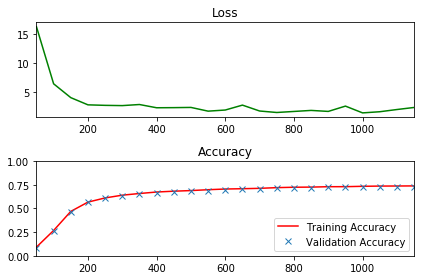

Validation accuracy at 0.7302666902542114


In [14]:
# Modifica el batch size si tu computadora pierde capacidad
batch_size = 128

# Encuentra la mejor combinación
epochs = 1
learning_rate = 0.1



### DON'T MODIFY ANYTHING BELOW ###
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

## Prueba
Ahora, entrenarás tu modelo utilizando tu base de datos de entrenamiento y prueba.

In [15]:
### DON'T MODIFY ANYTHING BELOW ###
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
print('Nice Job! Test Accuracy is {}'.format(test_accuracy))

Epoch  1/1: 100%|███████████████████████████████████████████████████████████| 1114/1114 [00:01<00:00, 1104.71batches/s]


Nice Job! Test Accuracy is 0.8080999851226807


# Ejercicio 4
Buen trabajo, al terminar el curso intenta agregar otras capas para mejorar el desempeño de tu red neuronal.